# 权重衰退

使用均方范数作为硬性限制
- 通过限制参数值的选择范围来控制模型容量
  
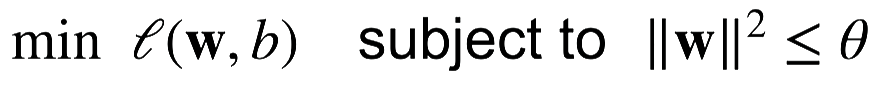

- 通常不限制偏移b(限不限制都差不多)
- 小的theta意味着更强的正则项

使用均方范数作为柔性限制
- 对每个theta，都可以找到lambda使得之前的目标函数等价于下面

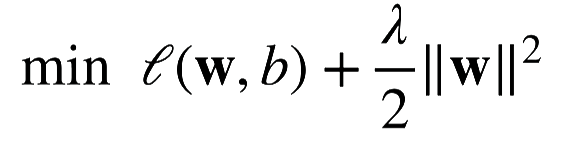

  - 可以通过拉格朗日乘子来证明
- 超参数lambda控制了正则项的重要程度
  - lambda = 0：无作用
  - lambda -> 无穷， w* -> 0

参数更新法则
- 计算梯度

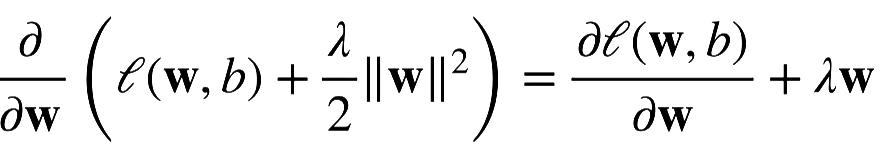

- 时间t更新参数
  
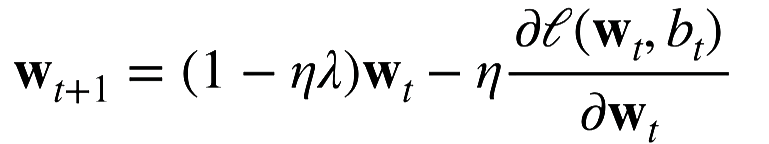

  - 通常 , 在深度学习中通常叫做权重衰退

总结
- 权重衰退通过L2正则项使得模型参数不会过大，从而控制模型复杂度
- 正则项权重是控制模型复杂度的超参数

In [1]:
#导入第三方库
#权重衰退是最广泛使用的正则化技术之一
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

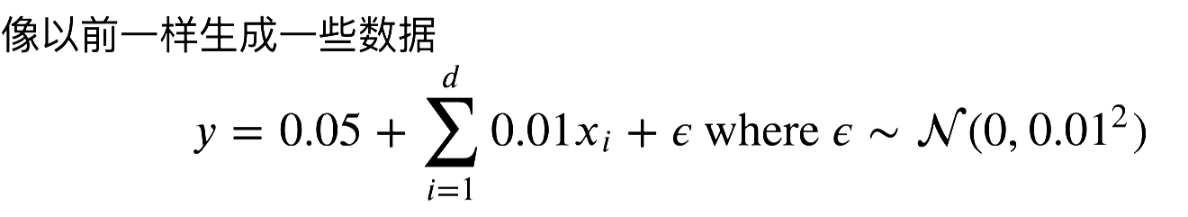

In [2]:
#定义模型训练集和测试集数量
#这里故意减少训练集的数量来实现过拟合现象
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1))* 0.01, 0.05
#根据模型参数创造训练数据和测试数据并创建对应的训练器
train_data = d2l.synthetic_data(true_w, true_b, n_train)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
train_iter = d2l.load_array(train_data, batch_size)
test_iter = d2l.load_array(test_data, batch_size, is_train= False)

In [3]:
#初始化模型参数
def init_params():
    """初始化模型参数"""
    #设置需要梯度计算
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad= True)
    b = torch.zeros(1, requires_grad= True)
    return [w, b]

In [4]:
#定义L2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [19]:
#定义训练代码实现
def train(lambd):
    w, b = init_params()
    #定义网络和损失
    net, loss = lambda X: d2l.linreg(X, w, b),  d2l.squared_loss
    #定义训练次数和学习率
    num_epochs, lr = 100, 0.003
    #动态绘制训练曲线
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #增加了L2惩罚系项
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            #反向传播
            l.sum().backward()
            #小批量随机梯度下降更新参数
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                                   d2l.evaluate_loss(net, test_iter, loss)))
    #训练结束后打印w的L2范数
    print('w的L2范数是:', torch.norm(w).item())

w的L2范数是: 12.551228523254395


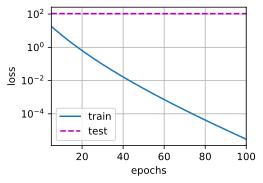

In [20]:
#忽略正则化直接训练
train(lambd= 0)

w的L2范数是: 0.3649505078792572


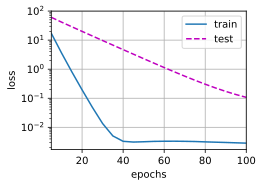

In [21]:
#使用权重衰减
train(lambd= 3)

## 权重衰减的简洁实现
权重衰减在神经网络优化中很常用，深度学习框架为了便于我们使用权重衰减

将权重衰减集成到优化算法中，以便与任何损失函数结合使用

好处：允许在不增加额外计算开销的情况下向算法中添加权重衰减，优化器必须与至少接触每个参数一次

In [16]:
#实例化优化器后直接通过weight_decay指定超参数
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction= 'none')
    num_epochs, lr = 100, 0.003
    #定义优化器，仅衰减权重
    trainer = torch.optim.SGD([{"params":net[0].weight, 'weight_decay': wd},
                               {"params":net[0].bias}], lr)
    #动态演示训练过程
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim= [5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #开始反向传播前将梯度清零
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            #更新参数
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss), 
                                   d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是:', net[0].weight.norm().item())

w的L2范数是: 14.314311027526855


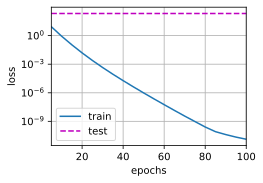

In [17]:
#不适用惩罚项
rain_concise(0)

w的L2范数是: 0.3528260588645935


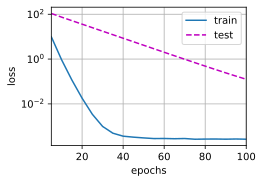

In [18]:
#进行权重衰减
train_concise(3)